# Broccoli pio simulation env

## Dev env


In [1]:
# 初回だけ実行
# %pip install pandas
# %pip install wavedrom
# %pip install svgwrite
# %pip install rp2040-pio-emulator@git+https://github.com/NathanY3G/rp2040-pio-emulator
# %pip install adafruit-circuitpython-pioasm

## Sim + Analysis

Pythonを使ったデバッグ環境向け。個々の内容は最終的にProductに持っていく必要はない

In [19]:
from dataclasses import dataclass
import json
from typing import Any, Callable, Dict, List, Optional
import pandas as pd
from collections import deque
import itertools
import adafruit_pioasm
import pioemu
import wavedrom
import svgwrite


def to_hex_u32(x: int) -> str:
    """32bit符号なし整数を16進数文字列に変換する"""
    return f"0x{(x& 0xffffffff):08X}"


def to_hex_str_arr(src: List[int]) -> List[str]:
    return [f"{x:#08x}" for x in src]


@dataclass
class EmulateResult:
    """PIOのエミュレーション結果を格納するクラス"""

    program_str: str
    test_cycles: int
    tx_fifo_entries: List[int]
    run_states_df: pd.DataFrame
    event_df: pd.DataFrame
    rx_fifo: List[int]
    received_from_rx_fifo: List[int]
    wavedrom_src: str
    wave_svg: svgwrite.drawing.Drawing


def emulate_pio(
    program_str: str,
    test_cycles: int,
    tx_fifo_entries: List[int] = [],
    dequeue_period_cyc: int = 0,
) -> EmulateResult:
    """PIOのsimulationを行う"""

    # emulation
    opcodes = adafruit_pioasm.assemble(program_str)
    generator = pioemu.emulate(
        opcodes=opcodes,
        stop_when=lambda _, state: state.clock > test_cycles,
        input_source=lambda clock: ((clock // 2) & 0xFF)
        | (
            0x8000 if (((clock // 8) % 2) == 1) else 0x0000
        ),  # TestReadData = ClockCycle | RBB
        initial_state=pioemu.State(
            clock=0,
            program_counter=0,
            transmit_fifo=deque(tx_fifo_entries),
            receive_fifo=deque([]),
            x_register=0,
            y_register=0,
        ),
        shift_isr_right=True,
        shift_osr_right=True,
        side_set_count=5,
        side_set_base=10,
    )

    # run
    run_states = []
    received_data = []
    dma_dequeue_ready_cnt = 0  # dequeue_period_cycより大きければDequeue可能
    for before, after in itertools.islice(generator, test_cycles):
        run_states.append(after.__dict__)
        # dequeue
        dma_dequeue_ready_cnt += 1
        if (dma_dequeue_ready_cnt > dequeue_period_cyc) and (
            len(before.receive_fifo) > 0
        ):
            received_data.append(after.receive_fifo.popleft())
            dma_dequeue_ready_cnt = 0

    run_states_df = pd.DataFrame.from_records(run_states)
    rx_fifo = list(run_states_df[-1:]["receive_fifo"].values[0])

    # 欲しいデータ抽出

    def get_insert_idx() -> int:
        """DataFrameに新しい列を挿入するためのインデックスを返す"""

        dst = get_insert_idx.insert_idx  # increment前を返す
        get_insert_idx.insert_idx += 1
        return dst

    get_insert_idx.insert_idx = 0

    run_states_df.insert(
        get_insert_idx(),
        "cyc",
        run_states_df["clock"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "pc",
        run_states_df["program_counter"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "inst",
        run_states_df["pc"].map(lambda pc: to_hex_u32(opcodes[pc])),
    )
    run_states_df.insert(
        get_insert_idx(), "x", run_states_df["x_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "y", run_states_df["y_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "isr",
        run_states_df["input_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(),
        "osr",
        run_states_df["output_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(), "pindirs", run_states_df["pin_directions"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "pins", run_states_df["pin_values"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "io",
        run_states_df["pin_values"].map(
            lambda data: to_hex_u32((data & 0x000000FF) >> 0)
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "io_dir",
        run_states_df["pin_directions"].map(
            lambda data: to_hex_u32((data & 0x000000FF) >> 0)
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ceb0",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000100) >> 8),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ceb1",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000200) >> 9),
    )
    run_states_df.insert(
        get_insert_idx(),
        "cle",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000400) >> 10),
    )
    run_states_df.insert(
        get_insert_idx(),
        "ale",
        run_states_df["pin_values"].map(lambda data: (data & 0x00000800) >> 11),
    )
    run_states_df.insert(
        get_insert_idx(),
        "wpb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00001000) >> 12),
    )
    run_states_df.insert(
        get_insert_idx(),
        "web",
        run_states_df["pin_values"].map(lambda data: (data & 0x00002000) >> 13),
    )
    run_states_df.insert(
        get_insert_idx(),
        "reb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00004000) >> 14),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rbb",
        run_states_df["pin_values"].map(lambda data: (data & 0x00008000) >> 15),
    )
    run_states_df.insert(
        get_insert_idx(),
        "txfifo_head",
        run_states_df["transmit_fifo"].map(
            lambda data: to_hex_u32(data[0]) if len(data) > 0 else None
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "txfifo_remain",
        run_states_df["transmit_fifo"].map(lambda data: len(data)),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rxfifo_tail",
        run_states_df["receive_fifo"].map(
            lambda data: to_hex_u32(data[-1]) if len(data) > 0 else None
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rxfifo_remain",
        run_states_df["receive_fifo"].map(lambda data: len(data)),
    )

    # シーケンス解析
    run_states_df["cs_assert"] = (run_states_df["ceb0"] == 0) | (
        run_states_df["ceb1"] == 0
    )
    # riseでNAND ICでキャプチャ想定
    run_states_df["web_edge"] = (run_states_df["web"] == 1) & (
        run_states_df.shift(1)["web"] == 0
    )
    # fallでICから出力、(t_rea遅れて) riseでPIOでキャプチャ想定。両方用意する
    run_states_df["reb_edge_nand"] = (run_states_df["reb"] == 0) & (
        run_states_df.shift(1)["reb"] == 1
    )
    run_states_df["reb_edge_pio"] = (run_states_df["reb"] == 1) & (
        run_states_df.shift(1)["reb"] == 0
    )
    run_states_df["reb_edge"] = run_states_df[
        "reb_edge_pio"
    ]  # PIOでrising edge時にキャプチャしたときの値で解析する

    run_states_df.insert(
        get_insert_idx(),
        "cmd_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 1)
        & (run_states_df["ale"] == 0),
    )
    run_states_df.insert(
        get_insert_idx(),
        "addr_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 1),
    )
    run_states_df.insert(
        get_insert_idx(),
        "data_in",
        run_states_df["web_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["reb"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 0),
    )
    run_states_df.insert(
        get_insert_idx(),
        "data_out",
        run_states_df["reb_edge"]
        & run_states_df["cs_assert"]
        & (run_states_df["web"] == 1)
        & (run_states_df["cle"] == 0)
        & (run_states_df["ale"] == 0),
    )

    # イベントだけを抽出しておく
    event_src = []
    for index, row in run_states_df.iterrows():
        event_type = None
        if row["cmd_in"]:
            event_type = "cmd_in"
        elif row["addr_in"]:
            event_type = "addr_in"
        elif row["data_in"]:
            event_type = "data_in"
        elif row["data_out"]:
            event_type = "data_out"
        else:
            continue
        event_src.append(
            {
                "cycle": row["cyc"],
                "pc": row["pc"],
                "event": event_type,
                "ceb0": row["ceb0"],
                "ceb1": row["ceb1"],
                "io": row["io"],
                "io_dir": row["io_dir"],
            }
        )
    event_df = pd.DataFrame.from_records(event_src)

    def to_wavedrom_signal(
        df: pd.DataFrame,
        col: str,
        replace_f: Optional[Callable[[Any, Any], Any]] = None,
    ) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].map(lambda x: "1" if x else "0").to_list()
        dst_wave = []

        prev_data = None
        for entry in src:
            # 差し替え関数あるなら任せる
            if replace_f is not None:
                dst_wave.append(replace_f(prev_data, entry))
            elif prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append(entry)
            # 一つ前のデータを保存
            prev_data = entry
        return {"name": col, "wave": "".join(dst_wave)}

    def to_wavedrom_data(df: pd.DataFrame, col: str) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].to_list()
        dst_wave = []
        dst_data = []

        prev_data = None
        for entry in src:
            # Noneのときは最初から一致してしまう
            if entry is None:
                dst_wave.append("x")
            elif prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append("=")
                dst_data.append(
                    hex(
                        int(entry, 16),
                    ).replace("0x", "")
                    if isinstance(entry, str)
                    else entry
                )  # 長いので縮める, str|intの場合分け
            # 一つ前のデータを保存
            prev_data = entry
        return {"name": col, "wave": "".join(dst_wave), "data": dst_data}

    wavedrom_src = json.dumps(
        {
            "signal": [
                [
                    "pio",
                    [
                        "ctrl",
                        to_wavedrom_data(run_states_df, "cyc"),
                        to_wavedrom_data(run_states_df, "pc"),
                        to_wavedrom_data(run_states_df, "inst"),
                        [
                            "fifo",
                            [
                                "tx",
                                to_wavedrom_data(run_states_df, "txfifo_head"),
                                to_wavedrom_data(run_states_df, "txfifo_remain"),
                            ],
                            [
                                "rx",
                                to_wavedrom_data(run_states_df, "rxfifo_tail"),
                                to_wavedrom_data(run_states_df, "rxfifo_remain"),
                            ],
                        ],
                    ],
                    {},
                    [
                        "regs",
                        [
                            "scratch",
                            to_wavedrom_data(run_states_df, "x"),
                            to_wavedrom_data(run_states_df, "y"),
                        ],
                        [
                            "fifo",
                            to_wavedrom_data(run_states_df, "isr"),
                            to_wavedrom_data(run_states_df, "osr"),
                        ],
                        [
                            "pinout",
                            to_wavedrom_data(run_states_df, "pindirs"),
                            to_wavedrom_data(run_states_df, "pins"),
                        ],
                    ],
                ],
                {},
                [
                    "nand",
                    [
                        "out",
                        [
                            "cs",
                            to_wavedrom_signal(run_states_df, "ceb0"),
                            to_wavedrom_signal(run_states_df, "ceb1"),
                        ],
                        [
                            "latch",
                            to_wavedrom_signal(run_states_df, "cle"),
                            to_wavedrom_signal(run_states_df, "ale"),
                        ],
                        [
                            "edge",
                            to_wavedrom_signal(run_states_df, "web"),
                            to_wavedrom_signal(run_states_df, "reb"),
                        ],
                        to_wavedrom_signal(run_states_df, "wpb"),
                    ],
                    {},
                    [
                        "inout",
                        to_wavedrom_data(run_states_df, "io"),
                        to_wavedrom_data(run_states_df, "io_dir"),
                    ],
                    {},
                    [
                        "in",
                        to_wavedrom_signal(run_states_df, "rbb"),
                    ],
                    {},
                    [
                        "analysis",
                        [
                            "src",
                            to_wavedrom_signal(run_states_df, "cs_assert"),
                            to_wavedrom_signal(run_states_df, "web_edge"),
                            to_wavedrom_signal(run_states_df, "reb_edge"),
                        ],
                        [
                            "event",
                            to_wavedrom_signal(run_states_df, "cmd_in"),
                            to_wavedrom_signal(run_states_df, "addr_in"),
                            to_wavedrom_signal(run_states_df, "data_in"),
                            to_wavedrom_signal(run_states_df, "data_out"),
                        ],
                    ],
                ],
            ]
        }
    )
    wave_svg = wavedrom.render(wavedrom_src)

    return EmulateResult(
        program_str=program_str,
        test_cycles=test_cycles,
        tx_fifo_entries=tx_fifo_entries,
        run_states_df=run_states_df,
        event_df=event_df,
        rx_fifo=rx_fifo,
        received_from_rx_fifo=received_data,
        wavedrom_src=wavedrom_src,
        wave_svg=wave_svg,
    )

## NAND IC + PIO Program Definition

実機に移植が必要な部分

In [23]:
from typing import List, Optional, Union
import pandas as pd
from enum import Enum, auto
from IPython.display import display
from pathlib import Path
import pandas as pd

#################################################
# NAND ICで決められた定義


class NandPinAssign(int, Enum):
    """
    NAND IC Pinout
    | 15  | 14  | 13  | 12  | 11  | 10  | 9    | 8    | 7   | 6   | 5   | 4   | 3   | 2   | 1   | 0   |
    | --- | --- | --- | --- | --- | --- | ---- | ---- | --- | --- | --- | --- | --- | --- | --- | --- |
    | rbb | reb | web | wpb | ale | cle | ceb1 | ceb0 | io7 | io6 | io5 | io4 | io3 | io2 | io1 | io0 |
    | in  | out | out | out | out | out | out  | out  | io  | io  | io  | io  | io  | io  | io  | io  |
    """

    Io0 = 0
    Io1 = 1
    Io2 = 2
    Io3 = 3
    Io4 = 4
    Io5 = 5
    Io6 = 6
    Io7 = 7
    Ceb0 = 8
    Ceb1 = 9
    Cle = 10
    Ale = 11
    Wpb = 12
    Web = 13
    Reb = 14
    Rbb = 15

def bit_on(bit_pos: int) -> int:
    """指定したbitだけ1の値"""
    return 0x01 << bit_pos


def combine_halfword(low: int, high: int) -> int:
    """2byteの値を結合する"""
    return (high << 16) | low


def gen_ceb_bits(select_cs: Optional[int] = None) -> int:
    """cs指定からCEB0/CEB1のピン状態を返す"""
    if select_cs is None:
        return bit_on(NandPinAssign.Ceb0.value) | bit_on(NandPinAssign.Ceb1.value)
    elif select_cs == 0:
        return bit_on(NandPinAssign.Ceb1.value)
    elif select_cs == 1:
        return bit_on(NandPinAssign.Ceb0.value)
    else:
        raise ValueError("select_cs must be 0 or 1 or None")


# RBB以外全部Output
write_pin_dir = (
    bit_on(NandPinAssign.Reb.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Ale.value)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Ceb1.value)
    | bit_on(NandPinAssign.Ceb0.value)
    | bit_on(NandPinAssign.Io7.value)
    | bit_on(NandPinAssign.Io6.value)
    | bit_on(NandPinAssign.Io5.value)
    | bit_on(NandPinAssign.Io4.value)
    | bit_on(NandPinAssign.Io3.value)
    | bit_on(NandPinAssign.Io2.value)
    | bit_on(NandPinAssign.Io1.value)
    | bit_on(NandPinAssign.Io0.value)
)

# RBB,IO以外Output
read_pin_dir = (
    bit_on(NandPinAssign.Reb.value)
    | bit_on(NandPinAssign.Web.value)
    | bit_on(NandPinAssign.Wpb.value)
    | bit_on(NandPinAssign.Ale.value)
    | bit_on(NandPinAssign.Cle.value)
    | bit_on(NandPinAssign.Ceb1.value)
    | bit_on(NandPinAssign.Ceb0.value)
)


# 単一コマンド、DataListへのCSセット用
def bitor_cs(
    data_src: Union[int, List[int]], select_cs: Optional[int]
) -> Union[int, List[int]]:
    """data_srcに対して、csを指定してCEB0/CEB1をセットする。単一変数・リストどちらでも対応"""
    if isinstance(data_src, int):
        return gen_ceb_bits(select_cs) | data_src
    else:
        return [gen_ceb_bits(select_cs) | data for data in data_src]


def gen_addressing(column_addr: int, page_addr: int, block_addr: int) -> List[int]:
    """アドレスをNAND Flashの指定フォーマットに変換する。Schematic Cell Layout and Address Assignment参照

    |              | I/O7 | I/O6 | I/O5 | I/O4 | I/O3 | I/O2 | I/O1 | I/O0 |
    | -------------|------|------|------|------|------|------|------|------|
    | First  cycle | CA7  | CA6  | CA5  | CA4  | CA3  | CA2  | CA1  | CA0  |
    | Second cycle | L    | L    | L    | L    | CA11 | CA10 | CA9  | CA8  |
    | Third  cycle | PA7  | PA6  | PA5  | PA4  | PA3  | PA2  | PA1  | PA0  |
    | Fourth cycle | PA15 | PA14 | PA13 | PA12 | PA11 | PA10 | PA9  | PA8  |

    - CA0 to CA11: Column address
    - PA0 to PA5: Page address in block
    - PA6 to PA15: Block address
    """
    ca = column_addr & 0xFFF
    pa = (page_addr & 0x3F) | ((block_addr & 0x3ff) << 6)
    return [
        ca & 0xFF,
        (ca >> 8) & 0x0F,
        pa & 0xFF,
        (pa >> 8) & 0xFF,
    ]


#################################################
# broccoli nandio 独自の定義


class BroccoliNandIoCommand(int, Enum):
    """Broccoli NAND IO Command"""

    Bitbang = 0x00
    CmdLatch = 0x01
    AddrLatch = 0x02
    DataOutput = 0x03
    DataInput = 0x04
    SetIrq = 0x05
    WaitRbb = 0x06

    def gen_cmd_header(
        self, pindirs: int, transfer_count: int, arg0: Optional[int]
    ) -> List[int]:
        """コマンドの先頭wordを返す. RShiftで取り出す想定. transfer_countに実際にセットされる値は、pio都合で-1される。"""
        return [
            # cmd_0 = { cmd_id[3:0], transfer_count[11:0], pindirs[15:0] }
            ((self.value & 0xF) << 28)
            | ((((transfer_count - 1) & 0x0FFF) << 16) | (pindirs & 0xFFFF)),
            # arg_0 = { arg0[31:0] }
            arg0 if arg0 is not None else 0x00000000,
        ]


def sim_broccoli(
    tx_fifo_entries: List[int],
    export_file_name: Optional[str] = None,
    test_cycles: int = 150,
    dequeue_period_cyc: int = 16,
) -> EmulateResult:
    """デバッグ用。Simの実行と結果表示を行う"""

    # PIO Assembler
    program = Path("broccoli-pio-nandio.pio").read_text(encoding="utf-8")
    result = emulate_pio(
        program,
        test_cycles=test_cycles,
        tx_fifo_entries=tx_fifo_entries,
        dequeue_period_cyc=dequeue_period_cyc,
    )

    pd.set_option("display.max_rows", 100)
    pd.set_option("display.max_columns", 100)

    # output logs
    if export_file_name is not None:
        Path("dst").mkdir(exist_ok=True)
        Path(f"dst/{export_file_name}").mkdir(exist_ok=True)
        Path(f"dst/{export_file_name}/broccoli-pio-nandio.pio").write_text(
            program, encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/tx_fifo.json").write_text(
            json.dumps(result.tx_fifo_entries), encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/rx_fifo.json").write_text(
            json.dumps(result.rx_fifo), encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/wave.json").write_text(result.wavedrom_src)
        result.run_states_df.to_csv(f"dst/{export_file_name}/run_states.csv")
        result.event_df.to_csv(f"dst/{export_file_name}/event.csv")
        result.wave_svg.saveas(f"dst/{export_file_name}/wave.svg")

    print(
        f"tx_fifo_entries: {len(result.tx_fifo_entries)} {to_hex_str_arr(result.tx_fifo_entries)}"
    )
    print(f"received_from_rx_fifo: {to_hex_str_arr(result.received_from_rx_fifo)}")
    print(f"rx_fifo: {to_hex_str_arr(result.rx_fifo)}")
    display(result.event_df)
    display(result.wave_svg)
    display(result.run_states_df)

    return result

----

# Command Debug

pio の TX/RX Fifoにデータを流し込む想定シーケンスを動かしてみる。部分的にProductへの移植が必要になると思われる

In [21]:

class NandFlashCommand(Enum):
    """NAND Flash Command"""

    SerialDataInput = 0x80
    Read1stCycle = 0x00
    Read2ndCycle = 0x30
    ReadWithDataCache = 0x31
    ReadStartForLastPageInReadCycleWithDataCache = 0x3F
    AutoPageProgram1stCycle = 0x80
    AutoPageProgram2ndCycle = 0x10
    ColumnAddressChangeInSerialDataInput = 0x85
    AutoPageProgramWithDataCache1stCycle = 0x80
    AutoPageProgramWithDataCache2ndCycle = 0x15
    ReadForPageCopyWithDataOut1stCycle = 0x00
    ReadForPageCopyWithDataOut2ndCycle = 0x3A
    AutoProgramWithDataCacheDuringPageCopy1stCycle = 0x8C
    AutoProgramWithDataCacheDuringPageCopy2ndCycle = 0x15
    AutoProgramForLastPageDuringPageCopy1stCycle = 0x8C
    AutoProgramForLastPageDuringPageCopy2ndCycle = 0x10
    AutoBlockErase1stCycle = 0x60
    AutoBlockErase2ndCycle = 0xD0
    ReadId = 0x90
    StatusRead = 0x70
    Reset = 0xFF


### Read (0x00, 0x30)

address_list: ['0x000023', '0x000001', '0x0000c5', '0x000019']
tx_fifo_entries: 22 ['0xfff6fff', '0x000300', '0xfff6fff', '0x000200', '0x10006fff', '0x000200', '0x20036fff', '0x000000', '0x000223', '0x000201', '0x0002c5', '0x000219', '0x10006fff', '0x000230', '0x6fff6fff', '0x000000', '0x30077f00', '0x000000', '0xfff6fff', '0x000300', '0x5fff6fff', '0x000000']
received_from_rx_fifo: ['0x2a000000', '0x2c000000', '0x2f000000', '0x31000000', '0x34000000', '0x36000000', '0x39000000', '0x3b000000']
rx_fifo: []


,cycle,pc,event,ceb0,ceb1,io,io_dir
0,26,0,cmd_in,0,1,0x00000000,0x000000FF
1,37,13,addr_in,0,1,0x00000023,0x000000FF
2,40,13,addr_in,0,1,0x00000001,0x000000FF
3,43,13,addr_in,0,1,0x000000C5,0x000000FF
4,46,16,addr_in,0,1,0x00000019,0x000000FF
5,57,0,cmd_in,0,1,0x00000030,0x000000FF
6,85,21,data_out,0,1,0x0000002A,0x00000000
7,90,21,data_out,0,1,0x0000002C,0x00000000
8,95,21,data_out,0,1,0x0000002F,0x00000000
9,100,21,data_out,0,1,0x00000031,0x00000000


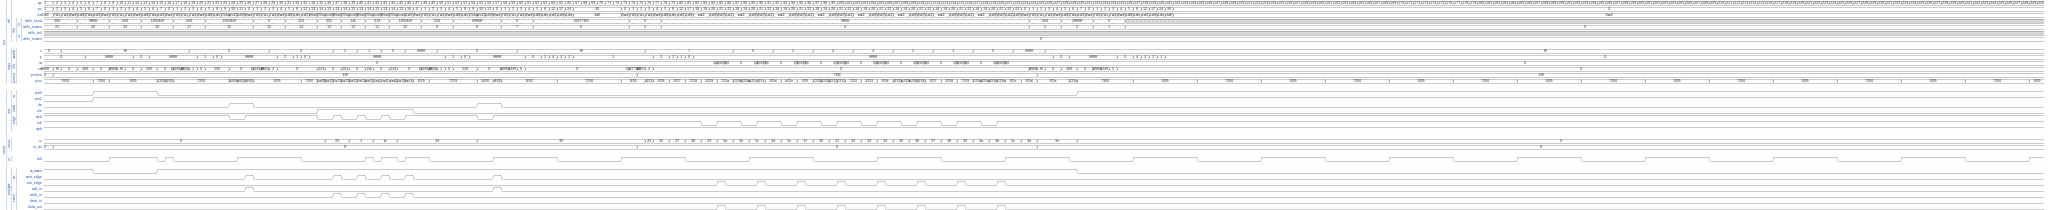

,cyc,pc,inst,x,y,isr,osr,pindirs,pins,io,io_dir,ceb0,ceb1,cle,ale,wpb,web,reb,rbb,txfifo_head,txfifo_remain,rxfifo_tail,rxfifo_remain,cmd_in,addr_in,data_in,data_out,clock,program_counter,pin_directions,pin_values,transmit_fifo,receive_fifo,input_shift_register,output_shift_register,x_register,y_register,cs_assert,web_edge,reb_edge_nand,reb_edge_pio,reb_edge
0,1,1,0x00007C90,0x00000000,0x00000000,0x00000000,0x0FFF6FFF,0x00000000,0x00007000,0x00000000,0x00000000,0,0,0,0,1,1,1,0,0x00000300,21,None,0,False,False,False,False,1,1,0,28672,"[768, 268398591, 512, 268464127, 512, 53709619...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=268398591, counter=0)",0,0,True,False,False,False,False
1,2,2,0x00007C2C,0x00000000,0x00000000,0x00000000,0x00000FFF,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x00000300,21,None,0,False,False,False,False,2,2,28671,28672,"[768, 268398591, 512, 268464127, 512, 53709619...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=4095, counter=16)",0,0,True,False,False,False,False
2,3,3,0x00007C44,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x00000300,21,None,0,False,False,False,False,3,3,28671,28672,"[768, 268398591, 512, 268464127, 512, 53709619...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=28)",4095,0,True,False,False,False,False
3,4,4,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x00000300,21,None,0,False,False,False,False,4,4,28671,28672,"[768, 268398591, 512, 268464127, 512, 53709619...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=32)",4095,0,True,False,False,False,False
4,5,5,0x00001C88,0x00000FFF,0x00000000,0x00000000,0x00000300,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x0FFF6FFF,20,None,0,False,False,False,False,5,5,28671,28672,"[268398591, 512, 268464127, 512, 537096191, 0,...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=768, counter=0)",4095,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007300,0x00000000,0x000000FF,1,1,0,0,1,1,1,0,None,0,None,0,False,False,False,False,246,0,28671,29440,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False
246,247,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007300,0x00000000,0x000000FF,1,1,0,0,1,1,1,0,None,0,None,0,False,False,False,False,247,0,28671,29440,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False
247,248,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007300,0x00000000,0x000000FF,1,1,0,0,1,1,1,0,None,0,None,0,False,False,False,False,248,0,28671,29440,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False
248,249,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x0000F300,0x00000000,0x000000FF,1,1,0,0,1,1,1,1,None,0,None,0,False,False,False,False,249,0,28671,62208,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False


In [29]:
select_cs = 0
column_addr = 0x123
page_addr = 0x45
block_addr = 0x67
address_list = gen_addressing(column_addr=column_addr, page_addr=page_addr, block_addr=block_addr)
read_bytes = 8  # (実際には2048+128byte単位で使いそう)

print(f"address_list: {to_hex_str_arr(address_list)}")

tx_fifo_entries = list(
    itertools.chain.from_iterable(
        [
            #############################################
            ### init pin (=negate cs) ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### assert cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=select_cs)
            ),
            #############################################
            ### CMD: READ ###
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.Read1stCycle.value, select_cs=select_cs),
            ),
            BroccoliNandIoCommand.AddrLatch.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=4, arg0=None
            ),
            bitor_cs(address_list, select_cs=select_cs),
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.Read2ndCycle.value, select_cs=select_cs),
            ),
            #############################################
            ### wait RBB ###
            BroccoliNandIoCommand.WaitRbb.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
            #############################################
            ### Read ###
            BroccoliNandIoCommand.DataOutput.gen_cmd_header(
                pindirs=read_pin_dir, transfer_count=read_bytes, arg0=None
            ),
            #############################################
            ### negate cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### set IRQ (& wait RBB) ###
            BroccoliNandIoCommand.SetIrq.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
        ]
    )
)

ret = sim_broccoli(tx_fifo_entries=tx_fifo_entries, export_file_name="read", test_cycles=250, dequeue_period_cyc=4)
## verify
# cmd=read1st
assert(ret.event_df.iloc[0]["event"] == "cmd_in")
assert(ret.event_df.iloc[0]["io"] == to_hex_u32(NandFlashCommand.Read1stCycle.value))
# # addr(column2byte+page2byte)
assert(ret.event_df.iloc[1]["event"] == "addr_in")
assert(ret.event_df.iloc[2]["event"] == "addr_in")
assert(ret.event_df.iloc[3]["event"] == "addr_in")
assert(ret.event_df.iloc[4]["event"] == "addr_in")
assert(ret.event_df.iloc[1]["io"] == to_hex_u32(address_list[0]))
assert(ret.event_df.iloc[2]["io"] == to_hex_u32(address_list[1]))
assert(ret.event_df.iloc[3]["io"] == to_hex_u32(address_list[2]))
assert(ret.event_df.iloc[4]["io"] == to_hex_u32(address_list[3]))
# cmd=read1st
assert(ret.event_df.iloc[5]["event"] == "cmd_in")
assert(ret.event_df.iloc[5]["io"] == to_hex_u32(NandFlashCommand.Read2ndCycle.value))
# data output
for i in range(0, read_bytes):
    assert(ret.event_df.iloc[6+i]["event"] == "data_out")


### Reset (0xff), READ ID (0x90)

tx_fifo_entries: 17 ['0xfff6fff', '0x000300', '0xfff6fff', '0x000200', '0x10006fff', '0x0002ff', '0x10006fff', '0x000290', '0x20006fff', '0x000000', '0x000200', '0x30047f00', '0x000000', '0xfff6fff', '0x000300', '0x5fff6fff', '0x000000']
received_from_rx_fifo: ['0x1d000000', '0x20000000', '0x22000000', '0x25000000', '0x27000000']
rx_fifo: []


,cycle,pc,event,ceb0,ceb1,io,io_dir
0,26,0,cmd_in,0,1,0x000000FF,0x000000FF
1,36,0,cmd_in,0,1,0x00000090,0x000000FF
2,47,16,addr_in,0,1,0x00000000,0x000000FF
3,60,21,data_out,0,1,0x0000001D,0x00000000
4,65,21,data_out,0,1,0x00000020,0x00000000
5,70,21,data_out,0,1,0x00000022,0x00000000
6,75,21,data_out,0,1,0x00000025,0x00000000
7,80,21,data_out,0,1,0x00000027,0x00000000


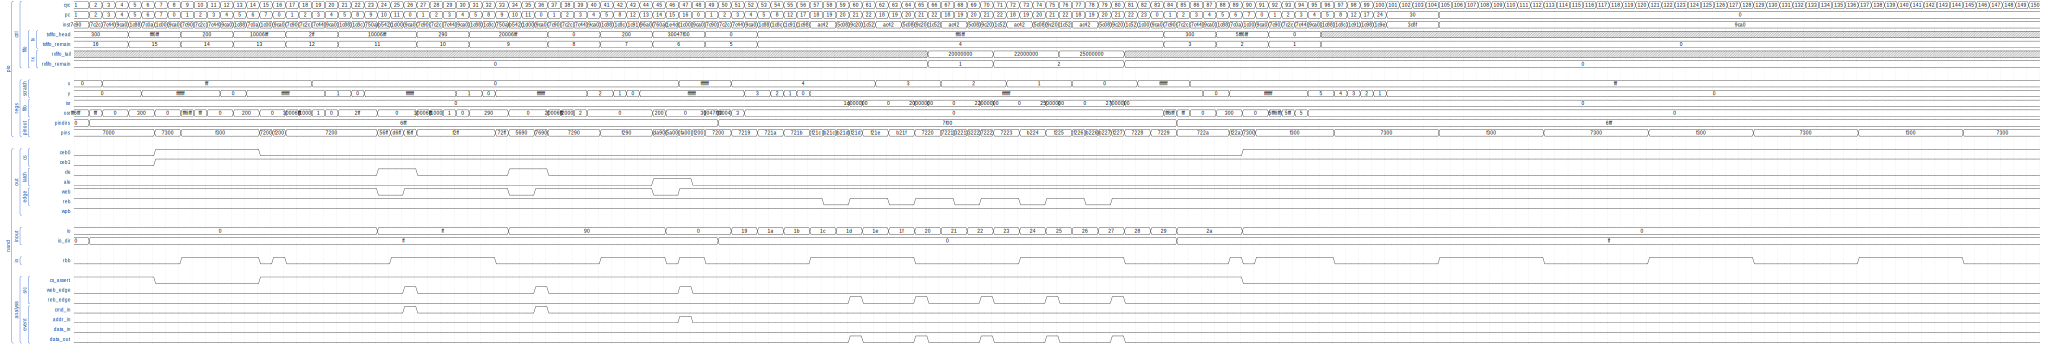

,cyc,pc,inst,x,y,isr,osr,pindirs,pins,io,io_dir,ceb0,ceb1,cle,ale,wpb,web,reb,rbb,txfifo_head,txfifo_remain,rxfifo_tail,rxfifo_remain,cmd_in,addr_in,data_in,data_out,clock,program_counter,pin_directions,pin_values,transmit_fifo,receive_fifo,input_shift_register,output_shift_register,x_register,y_register,cs_assert,web_edge,reb_edge_nand,reb_edge_pio,reb_edge
0,1,1,0x00007C90,0x00000000,0x00000000,0x00000000,0x0FFF6FFF,0x00000000,0x00007000,0x00000000,0x00000000,0,0,0,0,1,1,1,0,0x00000300,16,None,0,False,False,False,False,1,1,0,28672,"[768, 268398591, 512, 268464127, 767, 26846412...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=268398591, counter=0)",0,0,True,False,False,False,False
1,2,2,0x00007C2C,0x00000000,0x00000000,0x00000000,0x00000FFF,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x00000300,16,None,0,False,False,False,False,2,2,28671,28672,"[768, 268398591, 512, 268464127, 767, 26846412...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=4095, counter=16)",0,0,True,False,False,False,False
2,3,3,0x00007C44,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x00000300,16,None,0,False,False,False,False,3,3,28671,28672,"[768, 268398591, 512, 268464127, 767, 26846412...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=28)",4095,0,True,False,False,False,False
3,4,4,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x00000300,16,None,0,False,False,False,False,4,4,28671,28672,"[768, 268398591, 512, 268464127, 767, 26846412...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=32)",4095,0,True,False,False,False,False
4,5,5,0x00001C88,0x00000FFF,0x00000000,0x00000000,0x00000300,0x00006FFF,0x00007000,0x00000000,0x000000FF,0,0,0,0,1,1,1,0,0x0FFF6FFF,15,None,0,False,False,False,False,5,5,28671,28672,"[268398591, 512, 268464127, 767, 268464127, 65...",[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=768, counter=0)",4095,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007300,0x00000000,0x000000FF,1,1,0,0,1,1,1,0,None,0,None,0,False,False,False,False,146,0,28671,29440,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False
146,147,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007300,0x00000000,0x000000FF,1,1,0,0,1,1,1,0,None,0,None,0,False,False,False,False,147,0,28671,29440,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False
147,148,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007300,0x00000000,0x000000FF,1,1,0,0,1,1,1,0,None,0,None,0,False,False,False,False,148,0,28671,29440,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False
148,149,0,0x00009CA0,0x00000FFF,0x00000000,0x00000000,0x00000000,0x00006FFF,0x00007300,0x00000000,0x000000FF,1,1,0,0,1,1,1,0,None,0,None,0,False,False,False,False,149,0,28671,29440,[],[],"ShiftRegister(contents=0, counter=0)","ShiftRegister(contents=0, counter=0)",4095,0,False,False,False,False,False


In [16]:
select_cs = 0
tx_fifo_entries = list(
    itertools.chain.from_iterable(
        [
            #############################################
            ### init pin (=negate cs) ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### assert cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=select_cs)
            ),
            #############################################
            ### CMD: RESET ###
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.Reset.value, select_cs=select_cs),
            ),
            #############################################
            ### CMD: READ ID ###
            BroccoliNandIoCommand.CmdLatch.gen_cmd_header(
                pindirs=write_pin_dir,
                transfer_count=1,
                arg0=bitor_cs(NandFlashCommand.ReadId.value, select_cs=select_cs),
            ),
            BroccoliNandIoCommand.AddrLatch.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=1, arg0=None
            ),
            bitor_cs([0x00000000], select_cs=select_cs),
            #############################################
            ### Read: 5byte ###
            BroccoliNandIoCommand.DataOutput.gen_cmd_header(
                pindirs=read_pin_dir, transfer_count=5, arg0=None
            ),
            #############################################
            ### negate cs ###
            BroccoliNandIoCommand.Bitbang.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=bitor_cs(0x00, select_cs=None) # negate cs
            ),
            #############################################
            ### set IRQ (& wait RBB) ###
            BroccoliNandIoCommand.SetIrq.gen_cmd_header(
                pindirs=write_pin_dir, transfer_count=0, arg0=None
            ),
        ]
    )
)

ret = sim_broccoli(tx_fifo_entries=tx_fifo_entries, export_file_name="readid", test_cycles=150, dequeue_period_cyc=16)

## verify
# reset
assert(ret.event_df.iloc[0]["event"] == "cmd_in")
assert(ret.event_df.iloc[0]["io"] == to_hex_u32(NandFlashCommand.Reset.value))
# cmd=read id
assert(ret.event_df.iloc[1]["event"] == "cmd_in")
assert(ret.event_df.iloc[1]["io"] == to_hex_u32(NandFlashCommand.ReadId.value))
# addr=0x00
assert(ret.event_df.iloc[2]["event"] == "addr_in")
assert(ret.event_df.iloc[2]["io"] == to_hex_u32(0x0)) # 0x0固定
# data output
assert(ret.event_df.iloc[3]["event"] == "data_out")
assert(ret.event_df.iloc[4]["event"] == "data_out")
assert(ret.event_df.iloc[5]["event"] == "data_out")
assert(ret.event_df.iloc[6]["event"] == "data_out")
assert(ret.event_df.iloc[7]["event"] == "data_out")
